## Convolutional autoencoder (AE) for DICOM x-ray image denoising

In [1]:
#Import libraries & packages

import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, UpSampling2D
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, Conv2D, Reshape, Conv2DTranspose
#from tensorflow.keras.layers import Dense, Input, Dropout
from keras.preprocessing.image import ImageDataGenerator

from PIL import Image, ImageOps

import tensorflow as tf
from tensorflow import distribute

from sklearn.model_selection import train_test_split
from skimage import data
from skimage.filters.rank import gradient
from skimage.color import rgb2gray
from skimage.morphology import disk

import skimage
from skimage.metrics import structural_similarity as ssim


In [2]:
!pip install pydicom
import pydicom

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


6631180 2407 0
----------0.25x clinical----------
| original image size: 6631180 |
| maximum: 2407 |
| minimum: 0 |
---------------------------------


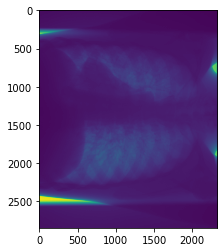

6631180 34091 493
--------3.2x clinical------------
| original image size: 6631180 |
| maximum: 34091 |
| minimum: 493 |
---------------------------------


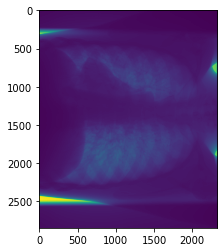

In [4]:
#reading in the DICOM images:

#LOW DOSE IMAGE
imagepath = '/content/gdrive/MyDrive/NoGrid/0.25xClinDose/DICOM/0001001A' #0.25x clinical dose - noisiest
data=pydicom.dcmread(imagepath)
reference=data.pixel_array
#Print size
refsize=reference.size
refmax=np.max(reference)
refmin=np.min(reference)
print(refsize,refmax,refmin)  
#show the image
print('----------0.25x clinical----------')
print('| original image size: %d'%(refsize), '|')
print('| maximum: %d'%(refmax), '|')
print('| minimum: %d'%(refmin), '|')
print('---------------------------------')
plt.imshow(reference/refmax)
plt.show()

#HIGH DOSE IMAGE (HD)
imagepath_hd = '/content/gdrive/MyDrive/NoGrid/3.2xClinDose/DICOM/0001001A' #3.2x clinical dose - least noisy
data_hd = pydicom.dcmread(imagepath_hd)
hd_reference=data_hd.pixel_array
#Print size
hdrefsize=hd_reference.size
hdrefmax=np.max(hd_reference)
hdrefmin=np.min(hd_reference)
print(hdrefsize,hdrefmax,hdrefmin)  
#show the image
print('--------3.2x clinical------------')
print('| original image size: %d'%(hdrefsize), '|')
print('| maximum: %d'%(hdrefmax), '|')
print('| minimum: %d'%(hdrefmin), '|')
print('---------------------------------')
plt.imshow(hd_reference/hdrefmax)
plt.show()


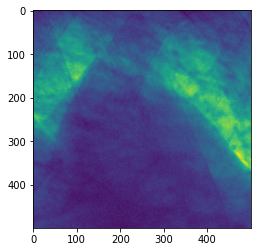

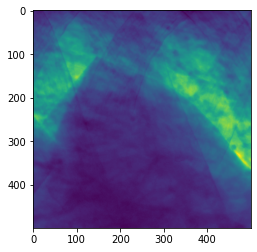

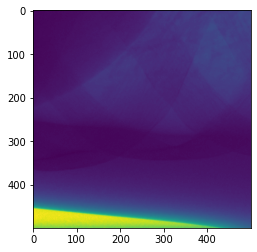

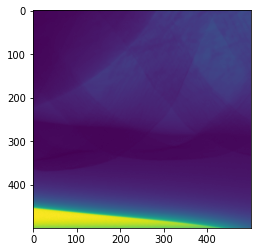

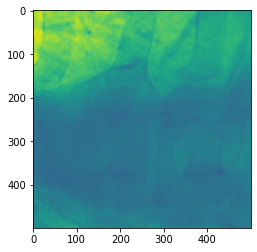

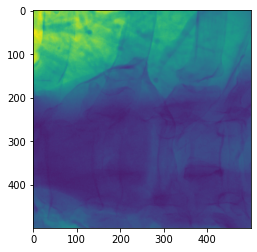

In [5]:
#define 'slices' of the image for computational efficiency

#1st slice (low & high dose)
ref1 = reference[500:1000,500:1000]
np.shape(ref1)
plt.imshow(ref1/np.max(ref1))
plt.show()

hd_ref1 = hd_reference[500:1000,500:1000]
np.shape(hd_ref1)
plt.imshow(hd_ref1/np.max(hd_ref1))
plt.show()

#2nd slice (low & high dose)
ref2 = reference[2000:2500,250:750]
np.shape(ref2)
plt.imshow(ref2/np.max(ref2))
plt.show()

hd_ref2 = hd_reference[2000:2500,250:750]
np.shape(hd_ref2)
plt.imshow(hd_ref2/np.max(hd_ref2))
plt.show()

#3rd slice (low & high dose)
ref3 = reference[1000:1500,1500:2000]
np.shape(ref3)
plt.imshow(ref3/np.max(ref3))
plt.show()

hd_ref3 = hd_reference[1000:1500,1500:2000]
np.shape(hd_ref3)
plt.imshow(hd_ref3/np.max(hd_ref3))
plt.show()

current image size: 500 x 500


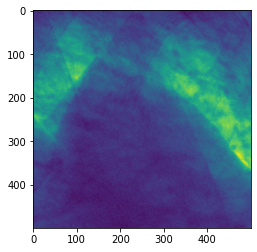

In [6]:
#Find out size of 1st image
width, height = ref1.shape  
print("current image size: %d x %d"%(width,height))

#show the image
plt.imshow(ref1)
plt.show()

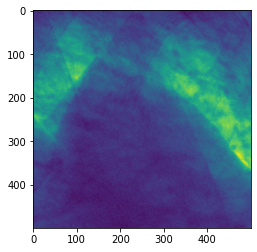

In [7]:
mywidth=500 #width
myheight=500 #height

#convert to an np array
ref1 = np.array(ref1)
hd_ref1= np.array(hd_ref1)
ref2 = np.array(ref2)
hd_ref2= np.array(hd_ref2)
ref3 = np.array(ref3)
hd_ref3= np.array(hd_ref3)

#print resulting image
plt.imshow(ref1)
plt.show()

In [8]:
myrefs = [ref1, ref2, ref3]
myhd_refs = [hd_ref1, hd_ref2, hd_ref3]

#add a channel index at the end of each np.array
channel1 = np.expand_dims(ref1, 2)
channel2 = np.expand_dims(hd_ref1, 2)

channel3 = np.expand_dims(ref2, 2)
channel4 = np.expand_dims(hd_ref2, 2)

channel5 = np.expand_dims(ref3, 2)
channel6 = np.expand_dims(hd_ref3, 2)

#using Keras' image_data_generator to create a dataset

#define each high dose and low dose samples variable as single image and add a dimension for each
samples= np.expand_dims(channel1, 0)
samples_hd = np.expand_dims(channel2, 0)
samples2 = np.expand_dims(channel3, 0)
samples_hd2 = np.expand_dims(channel4, 0)
samples3 = np.expand_dims(channel5, 0)
samples_hd3 = np.expand_dims(channel6, 0)

#image data augmentation generator
datagen = ImageDataGenerator(rotation_range=360,height_shift_range=0.25,width_shift_range=0.25,fill_mode='constant',)
datagen.fit(samples)
datagen.fit(samples_hd)
datagen.fit(samples2)
datagen.fit(samples_hd2)
datagen.fit(samples3)
datagen.fit(samples_hd3)

#create the new dataset from the original slices of the images

#storage arrays
clean=[] #high dose
noisy=[] #low dose

#instanciating the generator
it = datagen.flow(samples, batch_size=1)
it_hd = datagen.flow(samples_hd, batch_size=1)
it2 = datagen.flow(samples2, batch_size=1)
it_hd2 = datagen.flow(samples_hd2, batch_size=1)
it3 = datagen.flow(samples3, batch_size=1)
it_hd3 = datagen.flow(samples_hd3, batch_size=1)

#add the instances to the storage arrays
for i in range(40): #total dataset=240
    new_image=it.next()[0]
    new_image_hd=it_hd.next()[0]
for i in range(40):
    new_image2=it2.next()[0]
    new_image_hd2=it_hd2.next()[0]
for i in range(40):
    new_image3=it3.next()[0]
    new_image_hd3=it_hd3.next()[0]

# normalising (high dose only)
    clean.append(new_image_hd.astype('float32')/np.max(new_image_hd))
    clean.append(new_image_hd2.astype('float32')/np.max(new_image_hd2))
    clean.append(new_image_hd3.astype('float32')/np.max(new_image_hd))

#normalising (low dose only)
    noisy.append(new_image.astype('float32')/np.max(new_image))
    noisy.append(new_image2.astype('float32')/np.max(new_image2))
    noisy.append(new_image3.astype('float32')/np.max(new_image3))


#re-shaping the sets so that they are in the sample, x,y, channel order
created_set=np.reshape(clean, [-1, 500,500, 1])
noisycreated_set=np.reshape(noisy, [-1, 500,500, 1])

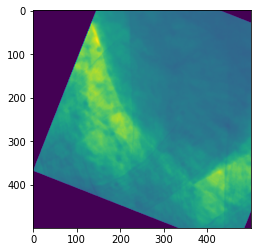

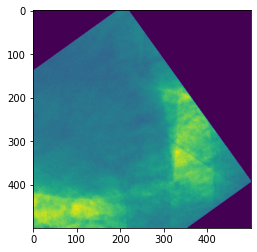

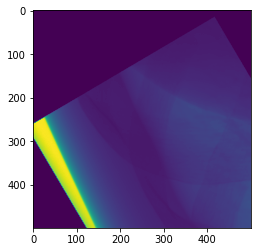

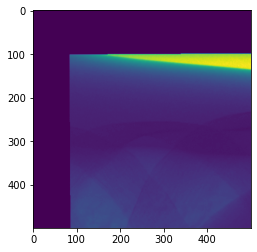

In [9]:
#Show outputs
plt.imshow(created_set[99,:,:,0]) #pic 99, channel 0
plt.show()
plt.imshow(noisycreated_set[99,:,:,0])
plt.show()
plt.imshow(created_set[97,:,:,0]) #pic 99, channel 0
plt.show()
plt.imshow(noisycreated_set[97,:,:,0])
plt.show()


In [10]:
#splitting the dataset into training and test (80/20)
X_train, X_test = train_test_split(noisycreated_set, test_size=0.2,random_state=2345173645)
y_train, y_test = train_test_split(created_set, test_size=0.2, random_state=2345173645)

In [11]:
#define custom SSIM Loss function
def SSIMLoss(y_true, y_pred):
    """Defines a custom loss function for SSIM measurement models
    Arguments: y_true, the true data, and y_pred, calculated prediction
    Returns: SSIMLoss loss function
    """
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [12]:
#network adapted from https://keras.io/examples/vision/autoencoder/

input = Input(shape=channel1.shape)

# Encoder
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input)
#x = MaxPooling2D((2, 2), padding="same")(x) #maxpooling seems to add unwanted fuzziness?
x = Conv2D(16, (3, 3), activation="relu", padding="same")(x) #alternative to upscaling
# x = MaxPooling2D((2, 2), padding="same")(x)
#x = Conv2D(8, (3, 3), activation="relu", padding="same")(x) #try with and without extra layers
#x = MaxPooling2D((2, 2), padding="same")(x)

# Decoder
#x = Conv2DTranspose(8, (3, 3), strides=1, activation="relu", padding="same")(x)
x = Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = Conv2DTranspose(32, (3, 3), strides=1, activation="relu", padding="same")(x)
x = Conv2D(1, (3, 3), activation="relu", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss=SSIMLoss)
#autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 500, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 500, 500, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 500, 500, 16)      4624      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 500, 500, 16)      2320      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 500, 500, 32)      4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 500, 500, 1)       289       
Total params: 12,193
Trainable params: 12,193
Non-trainable params: 0
_________________________________________________________

In [13]:
batch_size = 4
#training the model
history=autoencoder.fit(X_train, y_train,
              validation_data=(X_test, y_test),
              epochs=10,
              shuffle=True,
              batch_size=batch_size)

Epoch 1/10
24/24 [==============================] - 5s 71ms/step - loss: 0.4554 - val_loss: 0.3838
Epoch 2/10
24/24 [==============================] - 1s 58ms/step - loss: 0.3905 - val_loss: 0.3723
Epoch 3/10
24/24 [==============================] - 1s 58ms/step - loss: 0.3870 - val_loss: 0.3749
Epoch 4/10
24/24 [==============================] - 1s 60ms/step - loss: 0.3852 - val_loss: 0.3637
Epoch 5/10
24/24 [==============================] - 1s 58ms/step - loss: 0.3832 - val_loss: 0.3638
Epoch 6/10
24/24 [==============================] - 1s 58ms/step - loss: 0.3784 - val_loss: 0.3592
Epoch 7/10
24/24 [==============================] - 1s 58ms/step - loss: 0.3774 - val_loss: 0.3731
Epoch 8/10
24/24 [==============================] - 1s 58ms/step - loss: 0.3769 - val_loss: 0.3613
Epoch 9/10
24/24 [==============================] - 1s 58ms/step - loss: 0.3712 - val_loss: 0.3516
Epoch 10/10
24/24 [==============================] - 1s 58ms/step - loss: 0.3703 - val_loss: 0.3582


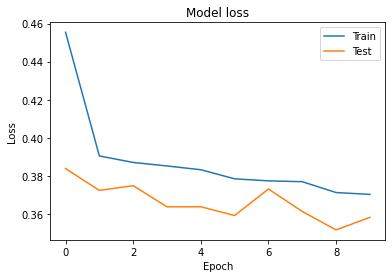

In [14]:
#plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#plt.ylim([0, 1])
plt.show()

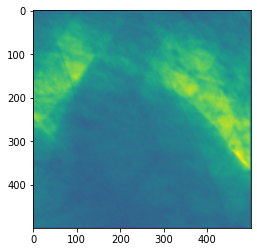

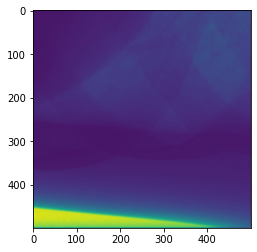

In [15]:
#predict the AE output from 'noisy' low dose test images
noisy_decoded = autoencoder.predict(samples)
plt.imshow(noisy_decoded.reshape(500,500))
plt.show()

noisy_decoded_2 = autoencoder.predict(samples2)
plt.imshow(noisy_decoded_2.reshape(500,500))
plt.show()

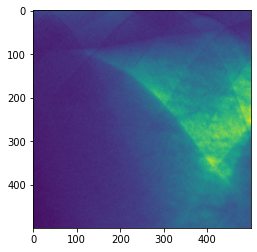

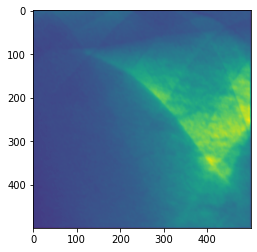

In [17]:
#try the model at predicting a completely new slice of the image. 

new_test_ref = reference[400:900,100:600]
np.shape(new_test_ref)
new_test_ref = np.array(new_test_ref)
new_test_ref = np.expand_dims(new_test_ref, 2)
new_test_ref = np.expand_dims(new_test_ref, 0)
new_test_ref.astype('float32')/np.max(new_test_ref)
new_decoded = autoencoder.predict(new_test_ref)
plt.imshow(new_test_ref.reshape(500,500))
plt.show()
plt.imshow(new_decoded.reshape(500,500))
plt.show()

In [18]:
#Comparison metrics
def mse(imageA, imageB):
    """Function to find MSE of 2 images
    Arguments: 2 images, imageA and imageB
    Returns: sum of squared difference between imageA and imageB
    """
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err


def sharpness_measure(imageA, imageB, title): 
  #adapted from https://dsp.stackexchange.com/questions/35490/how-to-locally-quantify-the-sharpness-of-an-image
    """function to show the sharpness of 2 side-by-side images as gradient maps
    Arguments: 2 images, title
    Returns: Plots of the 2 images with the difference in contrast (i.e., sharpness) measured by gradient
    """
    imageA_gray = rgb2gray(imageA)
    imageB_gray = rgb2gray(imageB)
    disk_matrix = disk(5) #matrix with a disk shape
    imageA_sharpness = gradient(imageA_gray, disk_matrix)
    imageB_sharpness = gradient(imageB_gray, disk_matrix)
    #Show first image
    plt.imshow(imageA_sharpness, cmap="viridis")
    plt.axis('off')
    plt.colorbar()
    plt.show()
    #show second image
    plt.imshow(imageB_sharpness, cmap="viridis")
    plt.axis('off')
    plt.colorbar()
    plt.show()
    

def compare_images(imageA, imageB, title):
    """function to compare SSIM and MSE for 2 images
    Arguments: 2 images, imageA and imageB, title
    Returns: Plotted images along with the MSE and SSIM values
    """
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB)
    # setup the figure
    fig = plt.figure(title)
    print("MSE: %.6f, SSIM: %.2f" % (m, s))
    plt.suptitle("MSE: %.6f, SSIM: %.2f" % (m, s))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA)#, cmap = plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB)#, cmap = plt.cm.gray)
    plt.axis("off")
    # show the images
    plt.show()

In [19]:
#Normalising images for comparison
Normalised_reference=hd_ref1.astype('float32')/65536.
Normalised_decoded=noisy_decoded[0].reshape(500,500)/np.max(noisy_decoded[0])
Normalised_noisy_original=ref1.astype('float32')/65536.

MSE: 0.188819, SSIM: 0.25


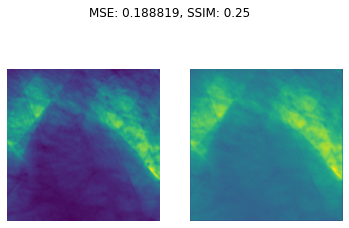

In [20]:
#Compare images clean reference with de-noised
compare_images(Normalised_reference,Normalised_decoded,"boo")
#for similarity want mse to be 0, ssim to be 1

MSE: 0.003600, SSIM: 0.22


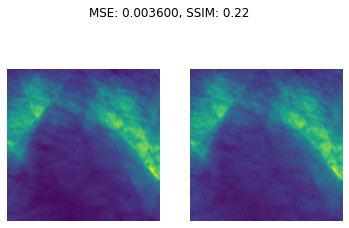

In [21]:
#Compare images clean reference with noisy original
compare_images(Normalised_reference, Normalised_noisy_original, "boo")

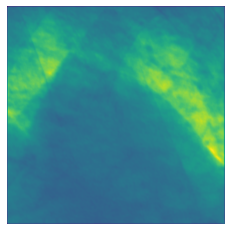

In [22]:
#save the decoded output image as as pdf
decodedimg = plt.figure()
plt.axis('off')
plt.imshow(Normalised_decoded)
plt.show()
decodedimg.savefig('decoded_dicom.pdf')

/usr/local/lib/python3.7/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


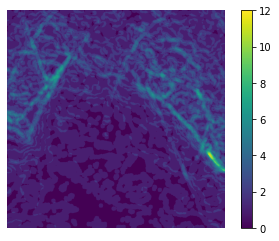

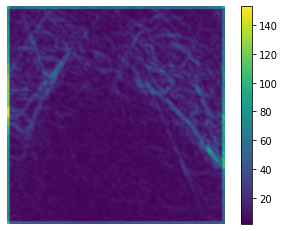

In [23]:
#image comparison for sharpness
sharpness_measure(Normalised_reference,Normalised_decoded, 'boo')